# Solving BPDN$_\infty$ for quantized Compressed sensing via the cvxopt package

$\newcommand{\eps}{\varepsilon}$
$\newcommand{\bR}{\mathbb{R}}$
$\newcommand{\bZ}{\mathbb{Z}}$
$\newcommand{\1}{{\rm 1}\kern-0.24em{\rm I}}$
$\newcommand{\inr}[1]{\bigl< #1 \bigr>}$

This notebooks is a simulations support for Section~7 of paper

> Sjoerd, Dirksen and Guillaume, Lecué and Holger, Rauhut, "ON THE GAP BETWEEN RIP-PROPERTIES AND SPARSE RECOVERY CONDITIONS"

We refer the reader to <a href="http://lecueguillaume.github.io/assets/gap_rip_reconstruction.pdf"> paper </a> for more details

In [1]:
from __future__ import division
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Import cvxopt library for solving our optimization problem

In [2]:
from cvxopt import solvers, matrix, spdiag, log, spmatrix, sparse # writting '%pylab inline' after those lines will cause trouble in the matrix method
solvers.options['show_progress'] = False

# Solving BPDN$_\infty$ via linear programming

Given a measurements matrix $A\in\bR^{m\times n}$ and $y=A\hat x + e$ where $||e||_\infty\leq \eps$, the Basis Pursuit Denoising program  BPDN$_\infty$ is the procedure

$$
min\big( ||t||_1: ||At-y||_\infty\leq \eps\big) \hspace{2cm} (P).
$$

This procedure can be recast as a linear program by introducing slack variables $z^+,z^-\in\bR^n$: problem~(P) is equivalent to

> $$\min_{z^+,z^-\in\bR^n} \sum_{j=1}^n z_i^+ + z_i^-$$

> subject to $$-\eps\leq [A|-A]\left[\begin{array}{c} z^+\\ z^-\end{array}\right]-y\leq \eps$$

> and $$\left[\begin{array}{c} z^+\\ z^-\end{array}\right]\geq 0$$

This is a linear program:

> $$\min_{\left[\begin{array}{c} z^+\\ z^-\end{array}\right]\in\bR^{2n}} \inr{a,\left[\begin{array}{c} z^+\\ z^-\end{array}\right]}$$

> subject to $$ M \left[\begin{array}{c} z^+\\ z^-\end{array}\right] \leq b$$

where

$$a = \left[\begin{array}{c} \1 \\ \1 \end{array}\right],\hspace{1cm} M = \left[\begin{array}{c}[A|-A]\\ [-A|A]\\ [-I_n|0]\\ [0|-I_n] \end{array}\right],\hspace{1cm} b = \left[\begin{array}{c}y + \eps \1\\ -y+\eps\1 \\ 0 \\ 0 \end{array}\right]$$

Solution to (P) is recovered via $t= z^+-z^-$.

### Construction of cvxopt matrices $a,M,b$
Given the measurement matrix $A\in\bR^{m\times n}$, the vector of measures $y\in\bR^m$ and a $\ell_\infty$ bound $\eps$ on the noise, we construct cvxopt matrices $a,M,b$ as in the Linear Programming formulation of BPDN$_\infty$.

In [3]:
def cvx_mat(A, y, eps):
    '''A, y: numpy array or cvx matrices
    eps : positive real number'''
    A = matrix(A)
    y = matrix(y)
    m, n = matrix(A).size
    # matrix a
    a = matrix(ones(2*n))
    # matrix M
    I_n = spdiag([1]*n)
    z_n = spdiag([0]*n)
    M = matrix([[A,-A, -I_n, z_n],[-A, A, z_n, -I_n]])
    # matrix b
    un_m = matrix(ones(m))
    zero_n = matrix(zeros(n))
    b = matrix([y + eps*un_m, -y + eps*un_m, zero_n, zero_n])
    return a, M, b

### Construction of sparse signals in $\bR^n$ and noisy measurements in $\bR^m$
We construct signals with sparsity given by *sparsity*, with a randomly chosen support in $\{1,\ldots,n\}$ and with none zero coefficients equal to $1$. 

We construct two types of measures:

1. measures are obtained by $y_i= \inr{A_{i,\cdot},signal} + e$ where $e$ is a variable chosen randomly in $[-\eps,\eps]$
2. measures are obtained by quantization; that is $y_i$ is equal to the closest point in $\eps\bZ$ of $\inr{A_{i,\cdot},signal}$

In [4]:
def signal(n, sparsity):
    sel = random.permutation(n)
    sel = sel[0:sparsity]   # indices of the nonzero elements of xsharp
    xsharp = zeros(n)
    xsharp[sel] = 1
    return xsharp

def measures(A, signal, eps):
    m, n = A.shape
    e = random.uniform(-eps, eps, (m,1))
    return [sum(a) for a in zip(dot(A, signal), e)]

def measures_quantized(A, signal, eps):
    y = dot(A, signal)
    if eps>0:
        y_q = [int(ele/eps)*eps for ele in y]
    else:
        y_q = y
    return y_q

### cvxopt linear solver  <a href="http://cvxopt.org/examples/tutorial/lp.html"> cvx lp </a>

####First try exact reconstruction by setting $\eps=0$

In [9]:
m , n, sparsity, eps = 15, 50, 3, 0
A, x_hat = randn(m, n), signal(n, sparsity)
y = measures(A, x_hat, eps)

In [10]:
a, M, b = cvx_mat(A, y, eps)
#print(a, M, b)

In [11]:
sol = solvers.lp(a, M, b)
sol = sol['x']
x_recover = sol[0:n] - sol[n:2*n]

In [12]:
norm(matrix(x_hat) - x_recover,2)

4.0640307445255899e-08

####Then try reconstruction from noisy measurements (i.e. noise level $\eps>0$)

In [13]:
m , n, sparsity, eps = 10, 40, 3, 0.1
A, x_hat = randn(m, n), signal(n, sparsity)

random noise

In [14]:
y = measures(A, x_hat, eps)
a, M, b = cvx_mat(A, y, eps)

In [15]:
sol = solvers.lp(a, M, b)
sol = sol['x']
x_recover = sol[0:n] - sol[n:2*n]
norm(matrix(x_hat) - x_recover,2)

1.1840669138367335

quantized measurements

In [16]:
y_quant = measures_quantized(A, x_hat, eps)
a, M, b = cvx_mat(A, y_quant, eps)

In [17]:
sol = solvers.lp(a, M, b)
sol = sol['x']
x_recover = sol[0:n] - sol[n:2*n]
norm(matrix(x_hat) - x_recover,2)

1.2310718900162763

# Phase transition diagram for BPDN$_\infty$

We construct two types of phase diagram:

1. One where the number of success is counted. We say that the reconstruction is a success when $||x_{hat}-x_{recover}||_2\leq 20\eps + 0.001$ (where *signal = $x_{hat}$*)
2. One where the errors $||x_{hat}-x_{recover}||_2$ are added for every pixel of the phase transition matrix (we don't have to decide wheither it is a succes or a failure)

####We start with a phase transition diagram where successes are counted; and for random uniform noise

In [18]:
def dist(x_hat, sol):
    n = len(x_hat)
    x_recover = sol[0:n] - sol[n:2*n]
    return norm(matrix(x_hat) - x_recover,2)

In [19]:
def phase_transition_mat(n, eps, nbtest):
    """return a n.n/2 matrix with the number of reconstruction success for every  1\leq m \leq n measurements 
    and sparsity 1\leq sparsity \leq n/2
    n : ambiant dimension of the signals
    eps : infinite norm of the additive noise (= twice the size of cells in CS quantization)
    nbtest : number of tests for each pixel"""
    PTM = zeros((n,int(n/2)))
    for m in range(1,n+1):#construct one line of the Phase transition matrix for a given number of measurements m
        if (m % 20) == 0:
            print("line number {} done".format(m))
        A = randn(m,n) / sqrt(m)
        for sparsity in range(1,min(m+1, int(n/2))+1):
            nb_success = 0         
            for i in range(nbtest):
                x_hat = signal(n, sparsity)
                y = measures(A, x_hat, eps)
                a, M, b = cvx_mat(A, y, eps)
                sol = solvers.lp(a, M, b)
                sol = sol['x']
                if dist(x_hat, sol) <= 20*eps+0.001:
                    nb_success = nb_success + 1
            PTM[m-1, sparsity-1] = nb_success
    return PTM

In [20]:
def frontier(mat, nbtest):
    """construction of the phase transition frontier, i.e. first time the number of success goes below nbtest/2"""
    L = []
    n = len(mat)
    for s in range(int(n/2)):
        m = 0
        while mat[m,s]<nbtest/2 and m<n-1:
            m = m + 1
        L.append(m)
    return L

In [21]:
n, eps, nbtest = 60, 0, 10
#solvers.options['show_progress'] = False # No logs printed
mat = phase_transition_mat(n, eps, nbtest)# construction of the matrix with the number of success among nbtest

line number 20 done
line number 40 done
line number 60 done


In [22]:
def mat_plot(mat, n, nbtest, titre):
    P_min, P_max, S_min, S_max = 0, n, 0, int(n/2)-1
    fig = plt.imshow(mat[P_min:P_max, S_min:S_max], interpolation="gaussian",  
                     aspect='auto', origin = 'lower', extent=[S_min, S_max, P_min, P_max])
    plt.title(titre)
    plt.xlabel('sparsity')
    plt.ylabel('number of measurements')

    #empirical phase transition
    X = range(int(n/2))
    L = frontier(mat, nbtest)
    plot(X,L, linewidth=4, color = 'black', label='phase transition')
    plt.legend(loc=4)   

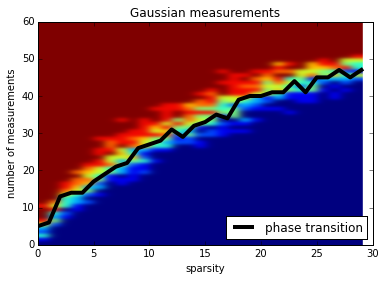

In [23]:
titre = "Gaussian measurements"
mat_plot(mat, n, nbtest, titre)
#filename = 'noisy_gaussian_{}_eps_{}.png'.format(n, eps)
#plt.savefig(filename,bbox_inches='tight')

####Now, we plot the phase transition where the reconstruction errors are added.
We explore both random noise and quantized measurements

In [24]:
def phase_transition_mat_sum_rand(n, eps, nbtest):
    """return a n.n/2 matrix with the sum of reconstruction errors at every pixel for every  1\leq m \leq n measurements 
    and sparsity 1\leq sparsity \leq n/2
    n : ambiant dimension of the signals
    eps : infinite norm of the additive noise (= twice the size of cells in CS quantization)
    nbtest : number of tests for each pixel"""
    PTM = zeros((n,int(n/2)))
    for m in range(1,n+1):#construct one line of the Phase transition matrix for a given number of measurements m
        if (m % 20) == 0:
            print("line number {} done".format(m))
        A = randn(m,n) / sqrt(m)
        ind_failure = 0
        for sparsity in range(1, int(n/2)+1):
            sum_errors = 0         
            for i in range(nbtest):
                x_hat = signal(n, sparsity)
                y = measures(A, x_hat, eps)
                a, M, b = cvx_mat(A, y, eps)
                sol = solvers.lp(a, M, b)
                sol = sol['x']
                sum_errors = sum_errors + dist(x_hat, sol)
            PTM[m-1, sparsity-1] = sum_errors
    return PTM

In [25]:
def frontier_sum(mat, eps, nbtest):
    """construction of the phase transition frontier, i.e. first time the number of success goes below nbtest/2"""
    L = []
    n = len(mat)
    for s in range(int(n/2)):
        m = 0
        while mat[m,s]> nbtest*(20*eps+1) and m<n-1:
            m = m + 1
        L.append(m)
    return L

In [26]:
def mat_plot_sum(mat, n, titre):
    P_min, P_max, S_min, S_max = 0, n, 0, int(n/2)-1
    fig = plt.imshow(mat[P_min:P_max, S_min:S_max], interpolation="gaussian",  
                     aspect='auto', origin = 'lower', extent=[S_min, S_max+1, P_min, P_max])
    plt.title(titre)
    plt.xlabel('sparsity')
    plt.ylabel('number of measurements')

    #empirical phase transition
    X = range(int(n/2))
    L = frontier_sum(mat, eps, nbtest)
    plot(X,L, linewidth=4, color = 'black', label='phase transition')
    plt.legend(loc=4) 

In [27]:
n, eps, nbtest = 80, 0.1, 10
start = time.time()
mat = phase_transition_mat_sum_rand(n, eps, nbtest)
print('{} seconds'.format(time.time() - start))

line number 20 done
line number 40 done
line number 60 done
line number 80 done
284.347899199 seconds


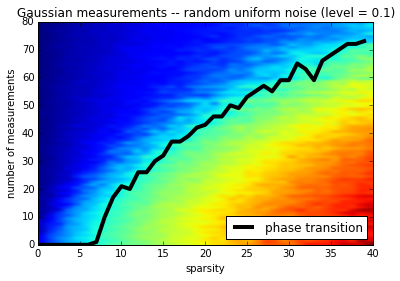

In [28]:
titre = "Gaussian measurements -- random uniform noise (level = {})".format(eps)
mat_plot_sum(mat, n, titre)
#filename = 'Gaussian_random_noise_n_{}_eps_{}.png'.format(n, eps)
#plt.savefig(filename,bbox_inches='tight')

####now for quantized measurements

In [29]:
def phase_transition_mat_sum_quant(n, eps, nbtest):
    """return a n.n/2 matrix with the sum of reconstruction errors at every pixel for every  1\leq m \leq n measurements 
    and sparsity 1\leq sparsity \leq n/2
    n : ambiant dimension of the signals
    eps : size of bins in CS quantization
    nbtest : number of tests for each pixel"""
    PTM = zeros((n,int(n/2)))
    for m in range(1,n+1):#construct one line of the Phase transition matrix for a given number of measurements m
        if (m % 20) == 0:
            print("line number {} done".format(m))
        A = randn(m,n) / sqrt(m)
        for sparsity in range(1, int(n/2)+1):
            sum_errors = 0         
            for i in range(nbtest):
                x_hat = signal(n, sparsity)
                y = measures_quantized(A, x_hat, eps)
                a, M, b = cvx_mat(A, y, eps)
                sol = solvers.lp(a, M, b)
                sol = sol['x']
                sum_errors = sum_errors + dist(x_hat, sol)
            PTM[m-1, sparsity-1] = sum_errors
    return PTM

In [30]:
n, eps, nbtest = 60, 0.1, 10
start = time.time()
mat = phase_transition_mat_sum_quant(n, eps, nbtest)
print('{} seconds'.format(time.time()-start))

line number 20 done
line number 40 done
line number 60 done
101.018029213 seconds


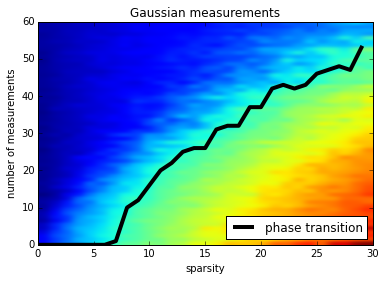

In [31]:
titre = "Gaussian measurements"
mat_plot_sum(mat, n, titre)
#filename = 'quantized_cs_gaussian_measures_n_{}_eps_{}.png'.format(n, eps)
#plt.savefig(filename,bbox_inches='tight')

### Repeat the construction of the frontier *nb_curves* times to "smooth it"

> nb_curves: number of phase transition curves constructed. Those curves are then averaged to "smooth" the effect of randomness in phase transition and get a "stable" phase transition

In [32]:
n, eps, nbtest, nb_curves = 40, 0.1, 10, 5
L = zeros(int(n/2))
start = time.time()
for i in range(nb_curves):
    if (i % 10) == 0:
        print('step {} done'.format(i))
    mat = phase_transition_mat_sum_quant(n, eps, nbtest)
    F = frontier_sum(mat, eps, nbtest)
    L = [sum(a) for a in zip(L,F)] 
L_gauss = [i/nb_curves for i in L]
print('{} seconds'.format(time.time()-start))

step 0 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
155.107507944 seconds


In [33]:
#For next use, save the Gaussian phase transition frontier with pickle
#import pickle
#filename = 'L_gauss_n_{}_eps_{}.p'.format(n, eps)

#Save L_gauss
#with open(filename, 'wb') as fp:
#    pickle.dump(L_gauss, fp)
    
#Load L_gauss
#filename = 'L_gauss_100_eps_0.1.p'
#with open(filename, 'rb') as fp:
#    L_gauss = pickle.load(fp)

### Draw the phase transition frontier for quantized CS for Gaussian measurements
(it took 38664.542408 seconds to get it for n, eps, nbtest, nb_curves = 100, 0.1, 15, 40)

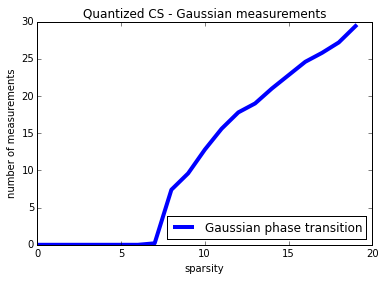

In [34]:
X = range(len(L_gauss))
plot(X,L_gauss, linewidth=4, color = 'blue', label="Gaussian phase transition")
titre = "Quantized CS - Gaussian measurements"
plt.title(titre)
plt.xlabel('sparsity')
plt.ylabel('number of measurements')
plt.legend(loc=4)
#filename = 'gaussian_phase_transition_quantized_cs_{}_eps_{}.png'.format(n, eps)
#plt.savefig(filename,bbox_inches='tight')

###Phase transition curves for $\Psi_\alpha$ variables

In [35]:
def mat_exp_power(m, n, alpha):
    A = randn(m, n)/ sqrt(m)
    return np.multiply(np.power(np.absolute(A),int(2/alpha)), sign(A))

In [36]:
def phase_transition_mat_sum_quant_exp_power(n, eps, nbtest, alpha):
    PTM = zeros((n,int(n/2)))
    for m in range(1,n+1):#construct one line of the Phase transition matrix for a given number of measurements m
        if (m % 20) == 0:
            print("line number {} done".format(m))
        A =  mat_exp_power(m, n, alpha)
        for sparsity in range(1, int(n/2)+1):
            sum_errors = 0         
            for i in range(nbtest):
                x_hat = signal(n, sparsity)
                y = measures_quantized(A, x_hat, eps)
                a, M, b = cvx_mat(A, y, eps)
                sol = solvers.lp(a, M, b)
                sol = sol['x']
                sum_errors = sum_errors + dist(x_hat, sol)
            PTM[m-1, sparsity-1] = sum_errors
    return PTM

In [37]:
n, eps, nbtest, nb_curves = 50, 0.1, 10, 5
L = zeros(int(n/2))
dict_power_quant_cs = {2: L, 1.5: L, 1: L, 0.5: L}# note that for alpha<0.5 cvxopt solver fails
#dict_power_quant_cs = {2: L, 1.8: L, 1.5: L, 1.3: L, 1: L, 0.8: L, 0.5: L}
for alpha in dict_power_quant_cs.keys():
    print('exp power {} running'.format(alpha))
    for i in range(nb_curves):
        mat = phase_transition_mat_sum_quant_exp_power(n, eps, nbtest, alpha)
        F = frontier_sum(mat, eps, nbtest)
        dict_power_quant_cs[alpha] = [sum(a) for a in zip(dict_power_quant_cs[alpha], F)] 
    dict_power_quant_cs[alpha] = [ele/nb_curves for ele in dict_power_quant_cs[alpha]]

exp power 1.5 running
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
exp power 1 running
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
exp power 2 running
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
exp power 0.5 running
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done


In [38]:
#save the dictionary of phase transitions curves to speed up later investigation
#import pickle
#filename = 'dictionnaries_quantized_cs_power_n_{}_eps_{}.p'.format(n, eps)
#with open(filename, 'wb') as fp:
#    pickle.dump(dict_power_quant_cs, fp)

#To load the dictionary
#with open(filename, 'rb') as fp:
#    dict_power_quant_cs = pickle.load(fp)

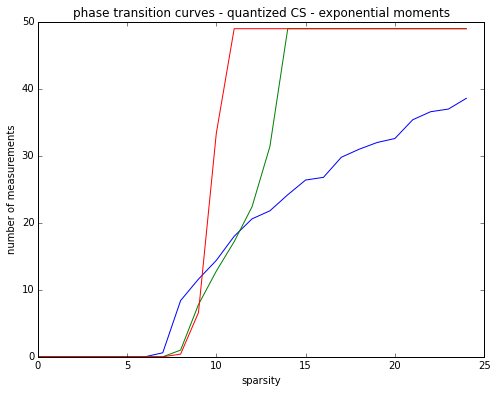

In [40]:
X = range(int(n/2))
plt.figure(figsize=(8,6))
for key in dict_power_quant_cs.keys():
    if key !=2:
        L = dict_power_quant_cs[key]
        text = 'exp power {}'.format(key)
        plot(X, L, label = text)
plt.xlabel('sparsity')
plt.ylabel('number of measurements')
plt.title('phase transition curves - quantized CS - exponential moments')
#Gaussian phase transition
#n_gauss = len(L_gauss)
#X_gauss = range(n_gauss)
#plot(X_gauss, L_gauss, 'r--', linewidth=3, label="Gaussian phase transition")
#plot(X, L_gauss[0:int(n/2)], 'r--', linewidth=3, label="Gaussian phase transition")
#plt.legend(loc=4)
#filename = "phase_transition_curves_quant_cs_n_{}_eps_{}.png".format(n, eps)
#plt.savefig(filename, bbox_inches='tight')

###Phase transition curves for Student variables

In [41]:
def mat_power(m, n, p):
    return random.standard_t(p, size=(m, n))

In [42]:
def phase_transition_mat_sum_quant_student(n, eps, nbtest, p):
    PTM = zeros((n,int(n/2)))
    for m in range(1,n+1):#construct one line of the Phase transition matrix for a given number of measurements m
        if (m % 20) == 0:
            print("line number {} done".format(m))
        A =  mat_power(m, n, p)
        for sparsity in range(1, int(n/2)+1):
            sum_errors = 0         
            for i in range(nbtest):
                x_hat = signal(n, sparsity)
                y = measures_quantized(A, x_hat, eps)
                a, M, b = cvx_mat(A, y, eps)
                sol = solvers.lp(a, M, b)
                sol = sol['x']
                sum_errors = sum_errors + dist(x_hat, sol)
            PTM[m-1, sparsity-1] = sum_errors
    return PTM

In [43]:
n, eps, nbtest, nb_curves = 40, 0.1, 10, 5
L = zeros(int(n/2))
#dict_quant_cs_student = {30: L, 20: L, 15: L, 10: L, 5: L, 4: L, 3: L, 2: L}
dict_quant_cs_student = {30: L, 20: L}
for p in dict_quant_cs_student.keys():
    print('power {} running'.format(p))
    for i in range(nb_curves):
        mat = phase_transition_mat_sum_quant_student(n, eps, nbtest, p)
        F = frontier_sum(mat, eps, nbtest)
        dict_quant_cs_student[p] = [sum(a) for a in zip(dict_quant_cs_student[p], F)] 
    dict_quant_cs_student[p] = [ele/nb_curves for ele in dict_quant_cs_student[p]]

power 20 running
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
power 30 running
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done
line number 20 done
line number 40 done


In [333]:
#save the dictionary of phase transitions curves to speed up later investigation
#import pickle
#filename = 'dictionnaries_quantized_cs_student_n_{}_eps_{}.p'.format(n, eps)
#with open(filename, 'wb') as fp:
#    pickle.dump(dict_quant_cs_student, fp)

#To load the dictionary
#with open(filename, 'rb') as fp:
#    dict_quant_cs_student = pickle.load(fp)

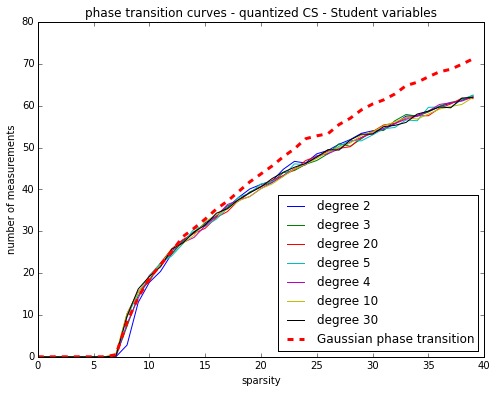

In [372]:
X = range(int(n/2))
plt.figure(figsize=(8,6))
for key in dict_quant_cs_student.keys():
    if key != 15:
        L = dict_quant_cs_student[key]
        text = 'degree {}'.format(key)
        plot(X, L, label = text)
plt.xlabel('sparsity')
plt.ylabel('number of measurements')
plt.title('phase transition curves - quantized CS - Student variables')
#Gaussian phase transition
#n_gauss = len(L_gauss)
#X_gauss = range(n_gauss)
plot(X, L_gauss[0:int(n/2)], 'r--', linewidth=3, label="Gaussian phase transition")
plt.legend(loc=4)
#filename = "phase_transition_curves_quant_cs_student_n_{}_eps_{}.png".format(n, eps)
#plt.savefig(filename, bbox_inches='tight')

#Reconstruction quality of BPDN$_\infty$ for large $n=1024$

Construction of phase transition diagrams may take a very long time in high dimensions (large values of $n$). That is the reason why we did not explore values of $n$ larger than $80$ (which is not high-dimensional).

In this last section, we explore a larger dimension $n=1024$. We consider the same simulation setup as the one in paper 
<a href = "http://arxiv.org/abs/0902.2367" > Dequantizing Compressed sensing </a> from L. Jacques, D.K. Hammond and J.M. Fadili:

1. $$SNR(signal, signal_{reconstruct}) = 20*\log_{10}\Big(\frac{||signal||_2}{||signal-signal_{reconstruct}||}_2\Big)$$
2. eps : size of bins in CS quantization equal to ||A signal||_\infty/40
3. $n=1024$, sparsity = 16, nbtest = 500
4. A coefficient is satisfying QC when 
$$|(A signal_{reconstruct})_i-y_i|\leq eps/2$$

In [22]:
def signal_gauss(n, sparsity):
    sel = random.permutation(n)
    sel = sel[0:sparsity]
    x = zeros(n)
    x[sel] = randn(sparsity)
    return x

def SNR(x_hat, sol):
    n = len(x_hat)
    x_recover = sol[0:n] - sol[n:2*n]
    return 20*log10(norm(x_hat,2)/norm(matrix(x_hat) - x_recover,2))

def QC(A, y, sol, eps):
    minus_x_recover = sol[n:2*n] - sol[0:n] 
    pred = dot(A, minus_x_recover)
    list_QC = [abs(sum(ele)) <= eps/2 for ele in zip(pred, y)]
    return sum(list_QC)/len(y)

In [36]:
def SNR_gauss_quant_cs(n, sparsity, nbtest, list_ratio):
    """Return a list of the average SNR(x_hat, sol) for different ratio m/sparsity
    n : ambiant dimension of the signals
    sparsity : sparsity of signal
    nbtest : number of tests for point"""
    list_SNR = []
    list_SNR_std = []
    list_QC = []
    list_measures = [ele*sparsity for ele in list_ratio]
    for m in list_measures:
        print("measurement {} running".format(m))
        A = randn(m,n)
        sum_snr = 0 
        sum_snr_square = 0
        sum_QC = 0
        for i in range(nbtest):
            x_hat = signal_gauss(n, sparsity)
            eps = float(max(abs(dot(A,x_hat)))/40)
            y = measures_quantized(A, x_hat, eps)
            a, M, b = cvx_mat(A, y, eps)
            sol = solvers.lp(a, M, b)
            sol = sol['x']
            sum_snr = sum_snr + SNR(x_hat, sol)
            sum_snr_square = sum_snr_square + SNR(x_hat, sol)**2
            sum_QC = sum_QC + QC(A, y, sol, eps)
        list_SNR.append(sum_snr/nbtest)
        list_SNR_std.append(sqrt(sum_snr_square/nbtest-(sum_snr/nbtest)**2))
        list_QC.append(sum_QC/nbtest)
    return list_SNR, list_SNR_std, list_QC

In [37]:
n, sparsity, nbtest, list_ratio = 1024, 16, 100, [10, 15 , 20, 25, 30, 35 , 40] 
start = time.time()
list_SNR_gauss, list_SNR_std_gauss, list_QC_gauss = SNR_gauss_quant_cs(n, sparsity, nbtest, list_ratio)
print('{} seconds'.format(time.time()-start))

measurement 160 running
measurement 240 running
measurement 320 running
measurement 400 running
measurement 480 running
measurement 560 running
measurement 640 running
3509.82822204 seconds


In [80]:
import pickle
#list_SNR_gauss_quant_cs = [list_SNR_gauss, list_SNR_std_gauss, list_QC_gauss]
#filename = 'snr_quant_gauss_n_{}_sparsity_{}_nbtest_{}.p'.format(n, sparsity, nbtest)
#with open(filename, 'wb') as fp:
#    pickle.dump(list_SNR_gauss_quant_cs, fp)

#To load the list_SNR
#filename = 'snr_quant_gauss_n_1024_sparsity_16_nbtest.p'
with open(filename, 'rb') as fp:
    list_SNR_gauss_quant_cs = pickle.load(fp)
list_SNR_gauss = list_SNR_gauss_quant_cs[0] 
list_SNR_std_gauss = list_SNR_gauss_quant_cs[1]  
list_QC_gauss = list_SNR_gauss_quant_cs[2]

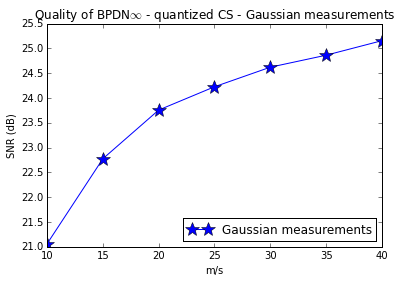

In [157]:
#plot(list_ratio, list_SNR_gauss, color='blue', marker='*', markersize=15, label='Gaussian measurements')#marker='^', 'o', '8', 'H', '+', 'x'
#plt.legend(loc = 4)
#plt.xlabel('m/s')
#plt.ylabel('SNR (dB)')
#plt.title('Quality of BPDN$\infty$ - quantized CS - Gaussian measurements')
#filename = 'snr_quant_gauss_n_{}_sparsity_{}.png'.format(n, sparsity)
#plt.savefig(filename, bbox_inches='tight')

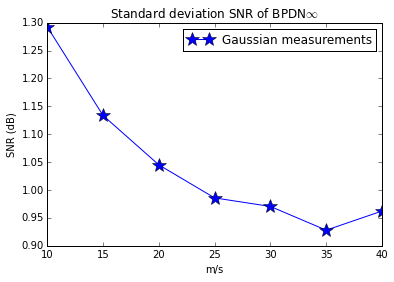

In [160]:
#plot(list_ratio, list_SNR_std_gauss, color='blue', marker='*', markersize=15, label='Gaussian measurements')
#plt.legend(loc = 4)
#plt.xlabel('m/s')
#plt.ylabel('SNR (dB)')
#plt.title('Standard deviation SNR of BPDN$\infty$')
#plt.legend(loc = 1)
#filename = 'snr_std_quant_gauss_n_{}_sparsity_{}.png'.format(n, sparsity)
#plt.savefig(filename, bbox_inches='tight')

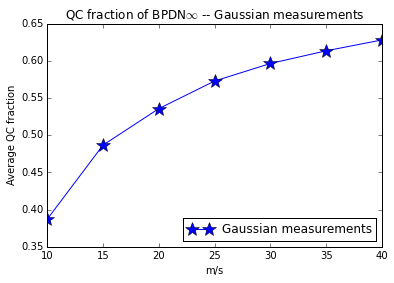

In [164]:
#plot(list_ratio, list_QC_gauss, color='blue', marker='*', markersize=15, label='Gaussian measurements')
#plt.xlabel('m/s')
#plt.ylabel('Average QC fraction')
#plt.title('QC fraction of BPDN$\infty$ -- Gaussian measurements')
#plt.legend(loc = 4)
#filename = 'snr_QC_quant_gauss_n_{}_sparsity_{}.png'.format(n, sparsity)
#plt.savefig(filename, bbox_inches='tight')

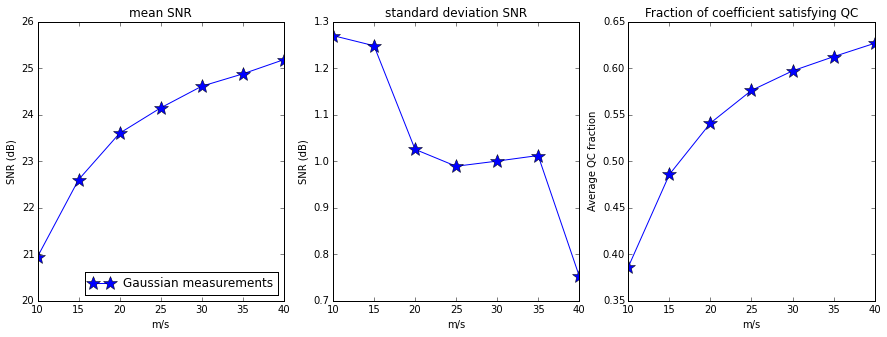

In [81]:
plt.figure(figsize=(15, 5))
subplot(131)
plot(list_ratio, list_SNR_gauss, color='blue', marker='*', markersize=15, label='Gaussian measurements')#marker='^', 'o', '8', 'H', '+', 'x'
plt.xlabel('m/s')
plt.ylabel('SNR (dB)')
plt.title('mean SNR')
plt.legend(loc = 4)
subplot(132)
plot(list_ratio, list_SNR_std_gauss, color='blue', marker='*', markersize=15, label='Gaussian measurements')#marker='^', 'o', '8', 'H', '+', 'x'
plt.xlabel('m/s')
plt.ylabel('SNR (dB)')
plt.title('standard deviation SNR')
subplot(133)
plot(list_ratio, list_QC_gauss, color='blue', marker='*', markersize=15, label='Gaussian measurements')
plt.xlabel('m/s')
plt.ylabel('Average QC fraction')
plt.title('Fraction of coefficient satisfying QC')
#filename = 'snr_subplots_quant_gauss_n_{}_sparsity_{}.png'.format(n, sparsity)
#plt.savefig(filename, bbox_inches='tight')

####Histogram of residuals for Gaussian measurements ($m=40*sparsity$)

In [201]:
def SNR_gauss_quant_cs_hist(n, sparsity, nbtest):
    """Return a list of the (normalized) prediction error (residuals) (A signal_reconstruct-y)_i
    n : ambiant dimension of the signals
    sparsity : sparsity of signal
    nbtest : number of tests for point"""
    m = 40*sparsity
    list_residue_avg = zeros(m)
    A = randn(m,n)/sqrt(m)
    for i in range(nbtest):
        x_hat = signal_gauss(n, sparsity)
        eps = float(max(abs(dot(A,x_hat)))/40)
        y = measures_quantized(A, x_hat, eps)
        a, M, b = cvx_mat(A, y, eps)
        sol = solvers.lp(a, M, b)
        sol = sol['x']
        minus_x_recover = sol[n:2*n] - sol[0:n] 
        pred = dot(A, minus_x_recover)
        list_residue = [sum(ele)/eps for ele in zip(pred, y)]
        list_residue_avg = list_residue_avg +  list_residue
    return list_residue_avg

In [202]:
n, sparsity, nbtest = 100, 4, 10#1024, 16, 100
start = time.time()
list_hist = SNR_gauss_quant_cs_hist(n, sparsity, nbtest)
print('{} seconds'.format(time.time()-start))

0.229198932648 seconds


In [198]:
#filename = "list_hist_gauss_n_{}_sparsity_{}_nbtest_{}.p".format(n, sparsity, nbtest)
#with open(filename, 'wb') as fp:
#    pickle.dump(list_hist, fp)
    
#with open(filename, 'rb') as fp:
#  pickleist_hist = pickle.load(fp)

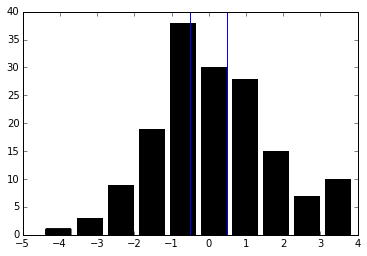

In [203]:
plt.hist(list_hist)#, bins=100, normed=True)
plt.axvline(x = 1/2)#, 'r--')#, linewidth=4)
plt.axvline(x = -1/2)#, 'r--')#, linewidth=4)
#filename = "list_hist_gauss_n_{}_sparsity_{}_nbtest_{}.png".format(n, sparsity, nbtest)
#plt.savefig(filename, bbox_inches='tight')

###SNR for exponential power measurements matrices

In [41]:
def mat_exp_power(m, n, alpha):
    A = randn(m, n)/ sqrt(m)
    return np.multiply(np.power(np.absolute(A),int(2/alpha)), sign(A))

In [42]:
def SNR_exp_power_quant_cs(n, sparsity, nbtest, list_ratio, list_exp_power):
    """Return a list of the average SNR(x_hat, sol) for different ratio m/sparsity
    n : ambiant dimension of the signals
    sparsity : sparsity of signal
    nbtest : number of tests for point"""
    dict_SNR_exp_power = {}
    list_measures = [ele*sparsity for ele in list_ratio]
    for alpha in list_exp_power:
        print("----- power {} running".format(alpha))
        list_SNR = []
        list_SNR_std = []
        list_QC = []
        for m in list_measures:
            print("measurement {} running".format(m))
            A = mat_exp_power(m, n, alpha)
            sum_snr = 0 
            sum_snr_square = 0
            sum_QC = 0
            for i in range(nbtest):
                x_hat = signal_gauss(n, sparsity)
                eps = float(max(abs(dot(A,x_hat)))/40)
                y = measures_quantized(A, x_hat, eps)
                a, M, b = cvx_mat(A, y, eps)
                sol = solvers.lp(a, M, b)
                sol = sol['x']
                sum_snr = sum_snr + SNR(x_hat, sol)
                sum_snr_square = sum_snr_square + SNR(x_hat, sol)**2
                sum_QC = sum_QC + QC(A, y, sol, eps)
            list_SNR.append(sum_snr/nbtest)
            list_SNR_std.append(sqrt(sum_snr_square/nbtest-(sum_snr/nbtest)**2))
            list_QC.append(sum_QC/nbtest)
        dict_SNR_exp_power[alpha] = [list_SNR, list_SNR_std, list_QC]
    return dict_SNR_exp_power

In [43]:
n, sparsity, nbtest, list_ratio, list_exp_power = 1024, 16, 100, [10, 15 , 20, 25, 30, 35 , 40], [2, 1.5, 1, 0.5]
dict_SNR_exp_power = SNR_exp_power_quant_cs(n, sparsity, nbtest, list_ratio, list_exp_power)

----- power 2 running
measurement 160 running
measurement 240 running
measurement 320 running
measurement 400 running
measurement 480 running
measurement 560 running
measurement 640 running
----- power 1.5 running
measurement 160 running
measurement 240 running
measurement 320 running
measurement 400 running
measurement 480 running
measurement 560 running
measurement 640 running
----- power 1 running
measurement 160 running
measurement 240 running
measurement 320 running
measurement 400 running
measurement 480 running
measurement 560 running
measurement 640 running
----- power 0.5 running
measurement 160 running
measurement 240 running
measurement 320 running
measurement 400 running
measurement 480 running
measurement 560 running
measurement 640 running


In [44]:
#import pickle
#filename = "dict_SNR_exp_power_n_{}_sparsity_{}_nbtest_{}.p".format(n, sparsity, nbtest)
#with open(filename, 'wb') as fp:
#    pickle.dump(dict_SNR_exp_power, fp)

#with open(filename, 'rb') as fp:
#    dict_SNR_exp_power = pickle.load(fp)

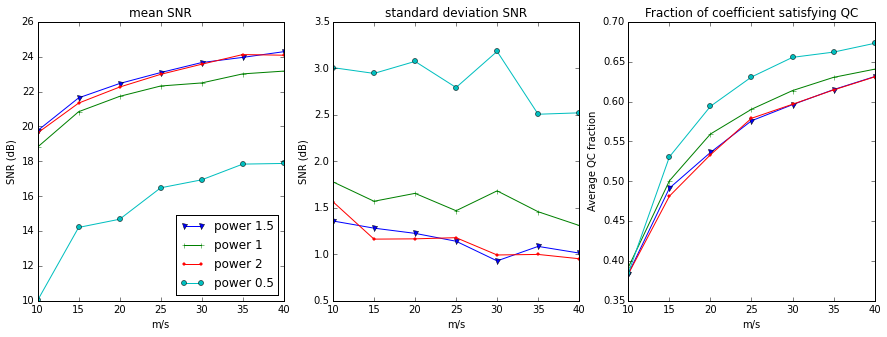

In [61]:
marker = ['v', '+', '.', 'o', '*'] 
plt.figure(figsize=(15, 5))
subplot(131)
ind = 0
for key in dict_SNR_exp_power.keys():
    L = dict_SNR_exp_power[key][0]
    text = 'power {}'.format(key)
    plot(list_ratio, L, marker = marker[ind], markersize=5, label=text)
    ind = ind + 1
plt.xlabel('m/s')
plt.ylabel('SNR (dB)')
plt.title('mean SNR')
plt.legend(loc = 4)
subplot(132)
ind = 0
for key in dict_SNR_exp_power.keys():
    L = dict_SNR_exp_power[key][1]
    text = 'power {}'.format(key)
    plot(list_ratio, L, marker = marker[ind], markersize=5, label=text)
    ind+=1
plt.xlabel('m/s')
plt.ylabel('SNR (dB)')
plt.title('standard deviation SNR')
subplot(133)
ind = 0
for key in dict_SNR_exp_power.keys():
    L = dict_SNR_exp_power[key][2]
    text = 'power {}'.format(key)
    plot(list_ratio, L,  marker = marker[ind], markersize=5, label=text)
    ind+=1
plt.xlabel('m/s')
plt.ylabel('Average QC fraction')
plt.title('Fraction of coefficient satisfying QC')
#filename = 'snr_subplots_quant_exp_power_n_{}_sparsity_{}_nbtest_{}.png'.format(n, sparsity, nbtest)
#plt.savefig(filename, bbox_inches='tight')

###SNR for Student measurements matrices 

In [64]:
def mat_power(m, n, p):
    return random.standard_t(p, size=(m, n))

In [67]:
def SNR_student_quant_cs(n, sparsity, nbtest, list_ratio, list_degrees):
    """Return a list of the average SNR(x_hat, sol) for different ratio m/sparsity
    n : ambiant dimension of the signals
    sparsity : sparsity of signal
    nbtest : number of tests for each point"""
    dict_SNR_student = {}
    list_measures = [ele*sparsity for ele in list_ratio]
    start = time.time()
    for p in list_degrees:
        print("---- degree {} running -- {} seconds".format(p, time.time()-start))
        list_SNR = []
        list_SNR_std = []
        list_QC = []
        for m in list_measures:
            print("measurement {} running".format(m))
            A = mat_power(m, n, p)
            sum_snr = 0 
            sum_snr_square = 0
            sum_QC = 0
            for i in range(nbtest):
                x_hat = signal_gauss(n, sparsity)
                eps = float(max(abs(dot(A,x_hat)))/40)
                y = measures_quantized(A, x_hat, eps)
                a, M, b = cvx_mat(A, y, eps)
                sol = solvers.lp(a, M, b)
                sol = sol['x']
                sum_snr = sum_snr + SNR(x_hat, sol)
                sum_snr_square = sum_snr_square + SNR(x_hat, sol)**2
                sum_QC = sum_QC + QC(A, y, sol, eps)
            list_SNR.append(sum_snr/nbtest)
            list_SNR_std.append(sqrt(sum_snr_square/nbtest-(sum_snr/nbtest)**2))
            list_QC.append(sum_QC/nbtest)
        dict_SNR_student[p] = [list_SNR, list_SNR_std, list_QC]
    return dict_SNR_student

In [68]:
n, sparsity, nbtest, list_ratio, list_degrees = 1024, 16, 200, [10, 15 , 20, 25, 30, 35 , 40], [2, 3, 5, 10, 20]
dict_SNR_student = SNR_student_quant_cs(n, sparsity, nbtest, list_ratio, list_degrees)

---- degree 2 running -- 9.53674316406e-07 seconds
measurement 160 running
measurement 240 running
measurement 320 running
measurement 400 running
measurement 480 running
measurement 560 running
measurement 640 running
---- degree 3 running -- 6223.41036606 seconds
measurement 160 running
measurement 240 running
measurement 320 running
measurement 400 running
measurement 480 running
measurement 560 running
measurement 640 running
---- degree 5 running -- 12929.707541 seconds
measurement 160 running
measurement 240 running
measurement 320 running
measurement 400 running
measurement 480 running
measurement 560 running
measurement 640 running
---- degree 10 running -- 19866.689492 seconds
measurement 160 running
measurement 240 running
measurement 320 running
measurement 400 running
measurement 480 running
measurement 560 running
measurement 640 running
---- degree 20 running -- 26878.2539561 seconds
measurement 160 running
measurement 240 running
measurement 320 running
measurement 400 r

In [69]:
#import pickle
#filename = "dict_SNR_student_n_{}_sparsity_{}_nbtest_{}.p".format(n, sparsity, nbtest)
#with open(filename, 'wb') as fp:
#    pickle.dump(dict_SNR_student, fp)

#with open(filename, 'rb') as fp:
#    dict_SNR_student = pickle.load(fp)

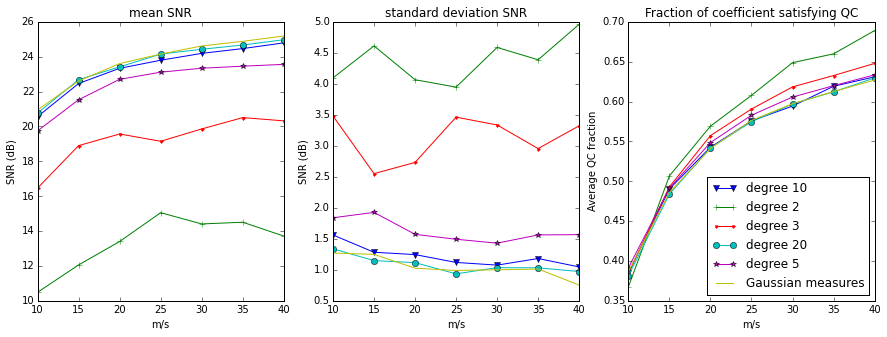

In [83]:
plt.figure(figsize=(15, 5))
marker = ['v', '+', '.', 'o', '*'] 
subplot(131)
ind = 0
for key in dict_SNR_student.keys():
    L = dict_SNR_student[key][0]
    text = 'degree {}'.format(key)
    plot(list_ratio, L, marker = marker[ind], label=text)
    ind+=1
plot(list_ratio, list_SNR_gauss , label='Gaussian measures')
plt.xlabel('m/s')
plt.ylabel('SNR (dB)')
plt.title('mean SNR')
subplot(132)
ind = 0
for key in dict_SNR_student.keys():
    L = dict_SNR_student[key][1]
    text = 'degree {}'.format(key)
    plot(list_ratio, L, marker = marker[ind], label=text)
    ind+=1
plot(list_ratio, list_SNR_std_gauss , label='Gaussian measures')
plt.xlabel('m/s')
plt.ylabel('SNR (dB)')
plt.title('standard deviation SNR')
subplot(133)
ind = 0
for key in dict_SNR_student.keys():
    L = dict_SNR_student[key][2]
    text = 'degree {}'.format(key)
    plot(list_ratio, L, marker = marker[ind], label=text)
    ind+=1
plot(list_ratio, list_QC_gauss , label='Gaussian measures')
plt.xlabel('m/s')
plt.ylabel('Average QC fraction')
plt.title('Fraction of coefficient satisfying QC')
plt.legend(loc = 4)
filename = 'snr_subplots_quant_student__n_{}_sparsity_{}.png'.format(n, sparsity)
plt.savefig(filename, bbox_inches='tight')

###histogram of residuals for Student variables

In [ ]:
def mat_power(m, n, p):
    return random.standard_t(p, size=(m, n))

In [ ]:
def SNR_student_quant_cs_hist(n, sparsity, nbtest, student_degree):
    """Return a list of the (normalized) prediction error (residuals) (A signal_reconstruct-y)_i
    n : ambiant dimension of the signals
    sparsity : sparsity of signal
    nbtest : number of tests for point"""
    m = 40*sparsity
    list_residue_avg = zeros(m)
    A = mat_power(m, n, student_degree)
    for i in range(nbtest):
        x_hat = signal_gauss(n, sparsity)
        eps = float(max(abs(dot(A,x_hat)))/40)
        y = measures_quantized(A, x_hat, eps)
        a, M, b = cvx_mat(A, y, eps)
        sol = solvers.lp(a, M, b)
        sol = sol['x']
        minus_x_recover = sol[n:2*n] - sol[0:n] 
        pred = dot(A, minus_x_recover)
        list_residue = [sum(ele)/eps for ele in zip(pred, y)]
        list_residue_avg = [sum(ele) for ele in zip(list_residue_avg, list_residue)]
    return [ele/nbtest for ele in list_residue_avg]

In [ ]:
n, sparsity, nbtest, student_degree = 100, 5, 10, 4
start = time.time()
list_student_hist = SNR_student_quant_cs_hist(n, sparsity, nbtest, student_degree)
print('{} seconds'.format(time.time()-start))

In [ ]:
#filename = "list_hist_student_n_{}_sparsity_{}_nbtest_{}_degree_{}.p".format(n, sparsity, nbtest, student_degree)
#with open(filename, 'wb') as fp:
#    pickle.dump(list_student_hist, fp)
    
#with open(filename, 'rb') as fp:
#    list_student_hist = pickle.load(fp)

In [ ]:
plt.hist(list_student_hist, bins=40, normed=True)
axvline(x = 1/2, linewidth=4, 'r--')
axvline(x = -1/2, linewidth=4,'r--')

#filename = "list_hist_student_n_{}_sparsity_{}_nbtest_{}_degree_{}.png".format(n, sparsity, nbtest, student_degree)
#plt.savefig(filename, bbox_inches='tight')

#Phase transition diagrams for correlated measurements
In this last section, we consider gaussian vectors with correlated entries as measurements vectors.

In [51]:
def covariance_mat(n, p):
    """covariance matrix with off-diagonal coefficients equal p and diagonal coefficients equal 0"""
    return (1-p)*identity(n) + p*ones((n,n))

def mat_gauss_corr(n, m, p):
    mean = zeros(n)
    cov = covariance_mat(n,p)
    return random.multivariate_normal(mean, cov, m)

In [52]:
def phase_transition_mat_sum_quant_gauss_corr(n, eps, nbtest, p):
    PTM = zeros((n,int(n/2)))
    for m in range(1,n+1):#construct one line of the Phase transition matrix for a given number of measurements m
        if (m % 20) == 0:
            print("line number {} done".format(m))
        A =  mat_gauss_corr(n, m, p)
        for sparsity in range(1, int(n/2)+1):
            sum_errors = 0         
            for i in range(nbtest):
                x_hat = signal(n, sparsity)
                y = measures_quantized(A, x_hat, eps)
                a, M, b = cvx_mat(A, y, eps)
                sol = solvers.lp(a, M, b)
                sol = sol['x']
                sum_errors = sum_errors + dist(x_hat, sol)
            PTM[m-1, sparsity-1] = sum_errors
    return PTM

In [53]:
n, eps, nbtest, nb_curves = 100, 0.1, 10, 10
L = zeros(int(n/2))
dict_gauss_corr_quant_cs = {0: L, 0.05: L, 0.1: L, 0.2: L}# note that for alpha<0.5 cvxopt solver fails
#dict_power_quant_cs = {2: L, 1.8: L, 1.5: L, 1.3: L, 1: L, 0.8: L, 0.5: L}
for p in dict_gauss_corr_quant_cs.keys():
    print('correlation parameter {} running'.format(p))
    for i in range(nb_curves):
        mat = phase_transition_mat_sum_quant_gauss_corr(n, eps, nbtest, p)
        F = frontier_sum(mat, eps, nbtest)
        dict_gauss_corr_quant_cs[p] = [sum(a) for a in zip(dict_gauss_corr_quant_cs[p], F)] 
    dict_gauss_corr_quant_cs[p] = [ele/nb_curves for ele in dict_gauss_corr_quant_cs[p]]

correlation parameter 0 running
line number 20 done
line number 40 done
line number 60 done
line number 80 done
line number 100 done
line number 20 done
line number 40 done
line number 60 done
line number 80 done
line number 100 done
line number 20 done
line number 40 done
line number 60 done
line number 80 done
line number 100 done
line number 20 done
line number 40 done
line number 60 done
line number 80 done
line number 100 done
line number 20 done
line number 40 done
line number 60 done
line number 80 done
line number 100 done
line number 20 done
line number 40 done
line number 60 done
line number 80 done
line number 100 done
line number 20 done
line number 40 done
line number 60 done
line number 80 done
line number 100 done
line number 20 done
line number 40 done
line number 60 done
line number 80 done
line number 100 done
line number 20 done
line number 40 done
line number 60 done
line number 80 done
line number 100 done
line number 20 done
line number 40 done
line number 60 done

In [54]:
#save the dictionary of phase transitions curves to speed up later investigation
#import pickle
#filename = 'dictionnaries_quantized_cs_gauss_corr_n_{}_eps_{}.p'.format(n, eps)
#with open(filename, 'wb') as fp:
#    pickle.dump(dict_gauss_corr_quant_cs, fp)

#To load the dictionary
#with open(filename, 'rb') as fp:
#    dict_gauss_corr_quant_cs = pickle.load(fp)

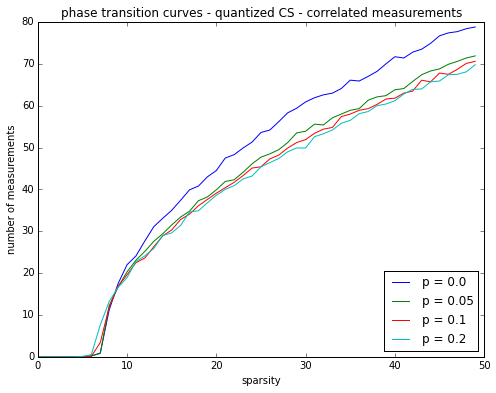

In [57]:
X = range(int(n/2))
plt.figure(figsize=(8,6))
for key in sort(list(dict_gauss_corr_quant_cs.keys())):
    L = dict_gauss_corr_quant_cs[key]
    text = 'p = {}'.format(key)
    plot(X, L, label = text)
plt.xlabel('sparsity')
plt.ylabel('number of measurements')
plt.title('phase transition curves - quantized CS - correlated measurements')
#Gaussian phase transition
#n_gauss = len(L_gauss)
#X_gauss = range(n_gauss)
#plot(X_gauss, L_gauss, 'r--', linewidth=3, label="Gaussian phase transition")
#plot(X, L_gauss[0:int(n/2)], 'r--', linewidth=3, label="Gaussian phase transition")
plt.legend(loc=4)
filename = "phase_transition_curves_quant_cs_gauss_corr_n_{}_eps_{}.png".format(n, eps)
plt.savefig(filename, bbox_inches='tight')